# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat('MR_data.mat')
# Input = mat['I_noisefree']
Input = mat['I_noisy1']
# Input = mat['I_noisy2']
# Input  = mat['I_noisy3']
# Input = mat['I_noisy4']

def wyswietlanie(I):
    plt.figure(dpi=200)
    plt.imshow(I, cmap ="gray")
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.show()

# wyswietlanie(I_noisefree)
# wyswietlanie(Input)
# wyswietlanie(I_noisy2)
# wyswietlanie(I_noisy3)
# wyswietlanie(I_noisy4)

--2021-01-22 16:45:38--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.64.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332591 (1,3M) [application/octet-stream]
Saving to: 'MR_data.mat'

     0K .......... .......... .......... .......... ..........  3%  769K 2s
    50K .......... .......... .......... .......... ..........  7% 6,71M 1s
   100K .......... .......... .......... .......... .......... 11%  799K 1s
   150K .......... .......... .......... .......... .......... 15%  581K 1s
   200K .......... .......... .......... .......... .......... 19%  429K 1s
   250K .......... .......... .......... .......... .......... 23%  643K 1s
   300K .......... .......... .......... .......... .......... 26%  774K 1s
   350K ......

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

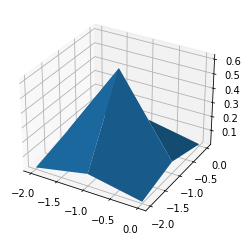

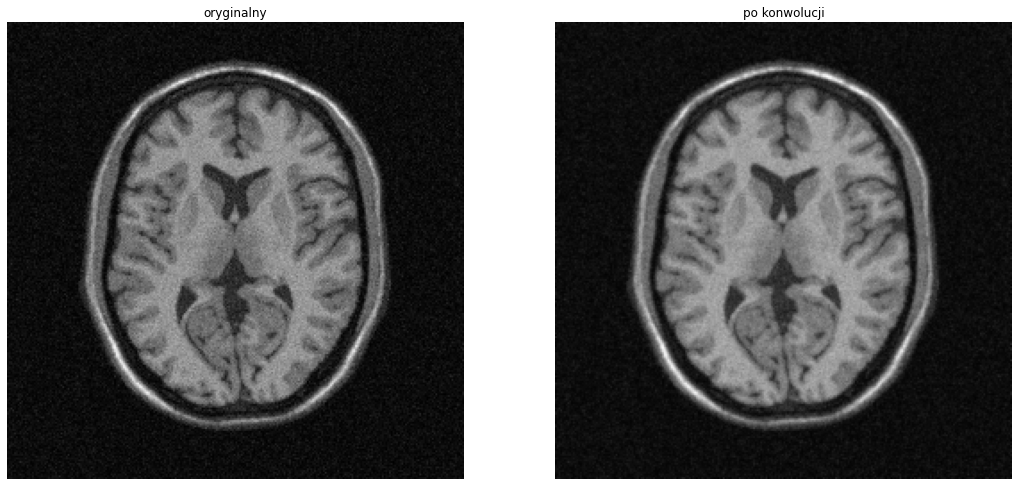

In [2]:
#TODO Samodzielna
rozmiar_okna = 3
wariancja = 0.5

def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     # x [[-1 -1 -1][ 0  0  0][ 1  1  1]]
     # y [[-1  0  1][-1  0  1][-1  0  1]]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum()

def mesh(fun, size):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    ax.plot_surface(X, Y, Z)
    plt.show()

def maska_gaussian(rozmiar_okna, wariancja):
    macierz = np.zeros((rozmiar_okna,rozmiar_okna))
    x_center = y_center = rozmiar_okna//2
    for i in range(rozmiar_okna):
        for j in range(rozmiar_okna):
            odleglosc = np.sqrt((x_center-i)**2 + (y_center-j)**2)
            macierz[i,j] = np.exp(-odleglosc**2/(2*np.square(wariancja)))
    macierz = macierz / macierz.sum()
    # print(macierz.sum())
    return macierz

# print(maska_gaussian(rozmiar_okna, wariancja))
# print(fgaussian(rozmiar_okna, wariancja))
# print(fgaussian(rozmiar_okna, wariancja).sum())
mesh(maska_gaussian(rozmiar_okna, wariancja),rozmiar_okna)


IConv = Input.copy()
srodek = rozmiar_okna//2
for i in range (srodek, IConv.shape[0]- srodek):
    for j in range (srodek, IConv.shape[1]- srodek):
        akt_kontekst = IConv[i-srodek:i+srodek+1, j-srodek:j+srodek+1]
        # maska = np.zeros((rozmiar_okna, rozmiar_okna))
        # print(akt_kontekst)
        # maska = np.multiply(maska_gaussian(rozmiar_okna, wariancja), akt_kontekst)
        maska = 0
        maska_gaussian_obl = maska_gaussian(rozmiar_okna, wariancja)
        for k in range (rozmiar_okna):
            for l in range (rozmiar_okna):
                maska = maska+maska_gaussian_obl[k,l] * akt_kontekst[k,l]
        IConv[i,j] = np.sum(maska)


_, (p1,p2) = plt.subplots(1, 2, figsize=(18,9))
p1.imshow(Input, cmap='gray')
p1.set_title("oryginalny")
p1.axis("off")
p2.imshow(IConv, cmap='gray')
p2.set_title("po konwolucji")
p2.axis("off")
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

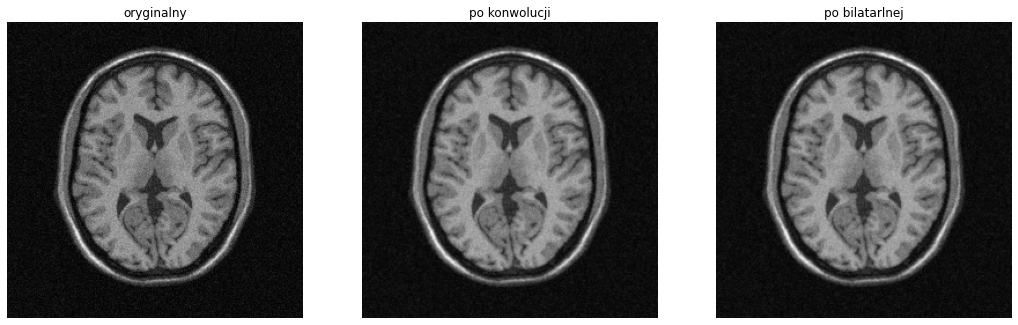

In [3]:
delta_R = 0.5

IBilateral = Input.copy()

odl_w_przeciw_obr = np.zeros((rozmiar_okna,rozmiar_okna))
x_center = y_center = rozmiar_okna//2
for i in range(rozmiar_okna):
    for j in range(rozmiar_okna):
        odleglosc_wartosci = np.sqrt(np.abs(Input[x_center, y_center]-Input[i,j]))
        odl_w_przeciw_obr[i,j] = np.exp(-odleglosc_wartosci**2/(2*delta_R**2))
odl_w_przeciw_obr = odl_w_przeciw_obr / odl_w_przeciw_obr.sum()


srodek = rozmiar_okna//2
maska_gaussian_obl = maska_gaussian(rozmiar_okna, wariancja)
# maska_gaussian_obl = fgaussian(rozmiar_okna, wariancja)
maska_final = np.multiply(maska_gaussian_obl, odl_w_przeciw_obr)
maska_final = maska_final / maska_final.sum()


for i in range (srodek, IConv.shape[0]- srodek):
    for j in range (srodek, IConv.shape[1]- srodek):
        akt_kontekst = IConv[i-srodek:i+srodek+1, j-srodek:j+srodek+1]
        maska = 0
        # print(maska_gaussian_obl.sum())
        # spr=0

        for k in range (rozmiar_okna):
            for l in range (rozmiar_okna):
                # spr+=maska_gaussian_obl[k,l] * odl_w_przeciw_obr[k,l]
                # maska = maska + (maska_gaussian_obl[k,l] * odl_w_przeciw_obr[k,l] * akt_kontekst[k,l])
                maska = maska + (maska_final[k,l] * akt_kontekst[k,l])
        IBilateral[i,j] = np.sum(maska)


_, (p1,p2,p3) = plt.subplots(1, 3, figsize=(18,9))
p1.imshow(Input, cmap='gray')
p1.set_title("oryginalny")
p1.axis("off")
p2.imshow(IConv, cmap='gray')
p2.set_title("po konwolucji")
p2.axis("off")
p3.imshow(IBilateral, cmap='gray')
p3.set_title("po bilatarlnej")
p3.axis("off")
plt.show()